# Fitting the background

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
from astropy.io import ascii

import corner
import glob
import pystan
import mystyle as ms
import pickle
import pandas as pd
import os

Lets read in the data

In [2]:
locs = np.genfromtxt('../scripts/locs.txt')
ff = np.genfromtxt('../scripts/freqs.txt')
pp = np.genfromtxt('../scripts/model.txt')

dnu = 102.
lo = locs.min() - .1*dnu
hi = locs.max() + .1*dnu
sel = (ff > lo) & (ff < hi)
f = ff[~sel]
p = pp[~sel]

In [16]:
binsize=2
m = int(len(p)/binsize)

bin_f = f[:m*binsize].reshape((m, binsize)).mean(1)
bin_p = np.sum(p[:m*binsize].reshape((m, binsize)),axis=1)

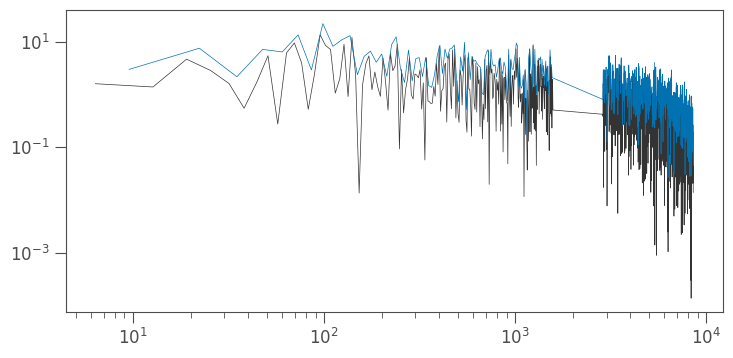

In [17]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(bin_f, bin_p)
    plt.yscale('log')
    plt.xscale('log')

In [5]:
overwrite = True
backfit = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    vector[N] f;
    vector[N] p;
    real white_est;
    real nyq_est;
    real numax_est;
    real scale_spread;
    int dof;
}
parameters {
    real loga;
    real logb;
    real logc;
    real logd;
    real logj;
    real logk;
    real lognumax;
    real<lower=0> white;
    real<lower=0> nyq;
    real scale;
}
transformed parameters {
    real numax;
    real logac = loga - logc;
    real logdb = logd - logb;
    
    numax = 10^lognumax;
}
model {
    real a = 10^loga;
    real b = 10^logb;
    real c = 10^logc;
    real d = 10^logd;
    real j = 10^logj;
    real k = 10^logk;
    real beta[N];

    for (i in 1:N){
        beta[i] = 1. / (apod(f[i], nyq) * scale
                * (harvey(f[i], a, b, 4.0)
                + harvey(f[i], c, d, 4.0)
                + harvey(f[i], j, k, 2.0))
                + white);
        }
    p ~ gamma(dof, beta);

    numax_est ~ normal(numax, numax_est*0.1);
    white ~ normal(white_est, white_est*0.3);
    nyq ~ normal(nyq_est, nyq_est*0.01);
    scale ~ normal(1, scale_spread);

    loga ~ normal(3.4 + lognumax *.48, 0.3);
    logb ~ normal(-0.43 + lognumax * 0.86, 0.3);
    logc ~ normal(3.59 + lognumax * -0.59, 0.3);
    logd ~ normal(0.02 + lognumax * 0.96, 0.3);
    logj ~ normal(loga-1, 1.2);
    logk ~ normal(logb-1, 0.2);
    
    logac ~ lognormal(1., 1.);
    logdb ~ lognormal(1., 1.);
}
'''
model_path = 'backfit.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_3d753037f9949e376c92e8bfa4750410 NOW.


Updating Stan model
Reading in Stan model


Guess the parameters

In [6]:
def guess(numax):
    ak, ae = 3.3, -0.48
    bk, be = -0.43, 0.86
    ck, ce = 3.59, -0.59
    dk, de = 0.02, 0.96

    a = 10**(ak + np.log10(numax)*ae)
    b = 10**(bk + np.log10(numax)*be)
    c = 10**(ck + np.log10(numax)*ce)
    d = 10**(dk + np.log10(numax)*de)
    j = a * 0.5
    k = b / 40.0
    scale = 1.0
    
    return [np.log10(a), np.log10(b), 
            np.log10(c), np.log10(d), 
            np.log10(j), np.log10(k), 
            np.log10(numax)]

## Fit regular

In [7]:
numax = 2200
white = 1.
p0 = guess(numax)

data = {'N': len(f), 
        'f': f, 'p': p,
        'numax_est': numax, 'white_est': white,
        'nyq_est': np.max(f),
        'scale_spread': 0.01, 'dof':1}

init = {'loga': p0[0], 'logb': p0[1], 
        'logc': p0[2], 'logd': p0[3],
        'logj': p0[4], 'logk': p0[5],
        'lognumax': p0[6],
        'white': white, 'nyq': np.max(f),
        'scale': 0.7}

In [8]:
nchains = 4
fit = sm.sampling(data=data, iter=5000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

## Fit binned

In [18]:
numax = 2200
white = 1.
p0 = guess(numax)

data = {'N': len(bin_f), 
        'f': bin_f, 'p': bin_p,
        'numax_est': numax, 'white_est': white,
        'nyq_est': np.max(f),
        'scale_spread': 0.01, 'dof':binsize}

init = {'loga': p0[0], 'logb': p0[1], 
        'logc': p0[2], 'logd': p0[3],
        'logj': p0[4], 'logk': p0[5],
        'lognumax': p0[6],
        'white': white, 'nyq': np.max(f),
        'scale': 0.7}

In [19]:
nchains = 4
bin_fit = sm.sampling(data=data, iter=5000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

## Fit mean binned

In [32]:
numax = 2200
white = 1.
p0 = guess(numax)

mean_f = f[:m*binsize].reshape((m, binsize)).mean(1)
mean_p = p[:m*binsize].reshape((m, binsize)).mean(1)

data = {'N': len(mean_f), 
        'f': mean_f, 'p': mean_p,
        'numax_est': numax, 'white_est': white,
        'nyq_est': np.max(f),
        'scale_spread': 0.01, 'dof':1}

init = {'loga': p0[0], 'logb': p0[1], 
        'logc': p0[2], 'logd': p0[3],
        'logj': p0[4], 'logk': p0[5],
        'lognumax': p0[6],
        'white': white, 'nyq': np.max(f),
        'scale': 0.7}

In [33]:
nchains = 4
mean_fit = sm.sampling(data=data, iter=5000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

## And lets look at the outputs

In [20]:
print(fit)

Inference for Stan model: backfit_3d753037f9949e376c92e8bfa4750410.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
loga       3.42  3.6e-3   0.26   2.91   3.24   3.41   3.59   3.91   5118    1.0
logb       0.11  2.7e-3   0.19  -0.26  -0.02   0.11   0.24   0.47   4858    1.0
logc       1.95  2.0e-4   0.02   1.92   1.94   1.95   1.96   1.98   6086    1.0
logd       3.67  4.9e-4   0.03   3.61   3.65   3.67    3.7   3.74   4638    1.0
logj        2.6  7.4e-3   0.26   2.15    2.5   2.63   2.74   2.95   1228    1.0
logk      -0.89  3.8e-3   0.28  -1.44  -1.08  -0.89   -0.7  -0.36   5332    1.0
lognumax   3.27  5.3e-4   0.06   3.15   3.23   3.27   3.31   3.37  10915    1.0
white      0.16  5.2e-4   0.03   0.09   0.14   0.16   0.18   0.22   4384    1.0
nyq      8529.6    0.77  85.91 8363.1 8472.6 8529.4 8587.5 8699.8  12401    1.0
scale       1

In [21]:
print(bin_fit)

Inference for Stan model: backfit_3d753037f9949e376c92e8bfa4750410.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
loga       3.42  3.5e-3   0.25   2.92   3.24   3.42   3.59   3.91   5236    1.0
logb       0.11  2.7e-3   0.19  -0.27  -0.02   0.11   0.24   0.48   4856    1.0
logc       1.95  1.9e-4   0.02   1.92   1.94   1.95   1.96   1.98   6706    1.0
logd       3.67  4.9e-4   0.03   3.61   3.65   3.67    3.7   3.74   4851    1.0
logj        2.6  6.6e-3   0.24   2.14   2.51   2.63   2.74   2.94   1345    1.0
logk      -0.89  3.8e-3   0.28  -1.42  -1.08  -0.89   -0.7  -0.34   5367    1.0
lognumax   3.27  5.4e-4   0.05   3.15   3.24   3.27   3.31   3.37  10236    1.0
white      0.16  5.2e-4   0.03   0.09   0.14   0.16   0.18   0.22   4574    1.0
nyq      8529.9    0.78  85.55 8363.8 8471.8 8530.7 8587.1 8697.0  11916    1.0
scale       1

In [34]:
print(mean_fit)

Inference for Stan model: backfit_3d753037f9949e376c92e8bfa4750410.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
loga       3.54  3.2e-3   0.25   3.04   3.37   3.54   3.71   4.03   6209    1.0
logb       0.33  2.6e-3   0.19  -0.05    0.2   0.33   0.46   0.71   5387    1.0
logc       1.94  2.8e-4   0.02    1.9   1.93   1.94   1.96   1.98   5855    1.0
logd       3.66  7.0e-4   0.05   3.57   3.63   3.66   3.69   3.75   4334    1.0
logj       2.16    0.01    0.7   0.21   1.94    2.4   2.62   2.89   2559    1.0
logk      -0.68  3.5e-3   0.28  -1.21  -0.86  -0.67  -0.49  -0.13   6188    1.0
lognumax   3.28  6.4e-4   0.05   3.16   3.24   3.28   3.32   3.37   7114    1.0
white      0.18  7.3e-4   0.05   0.08   0.14   0.18   0.21   0.27   4230    1.0
nyq      8529.3    0.85  84.64 8364.0 8471.7 8529.2 8586.5 8697.9   9901    1.0
scale       1

In [23]:
a = 36.3                                                                
b = 723.52                                                              
c = 31.85                                                               
d = 2002.6                                                              
j = 1.79                                                                
k = 198.31                                                              
white = 0.09  
truths = [np.log(a), np.log(b), np.log(c), np.log(d), np.log(j), np.log(k), white, numax, 1., f[-1]]

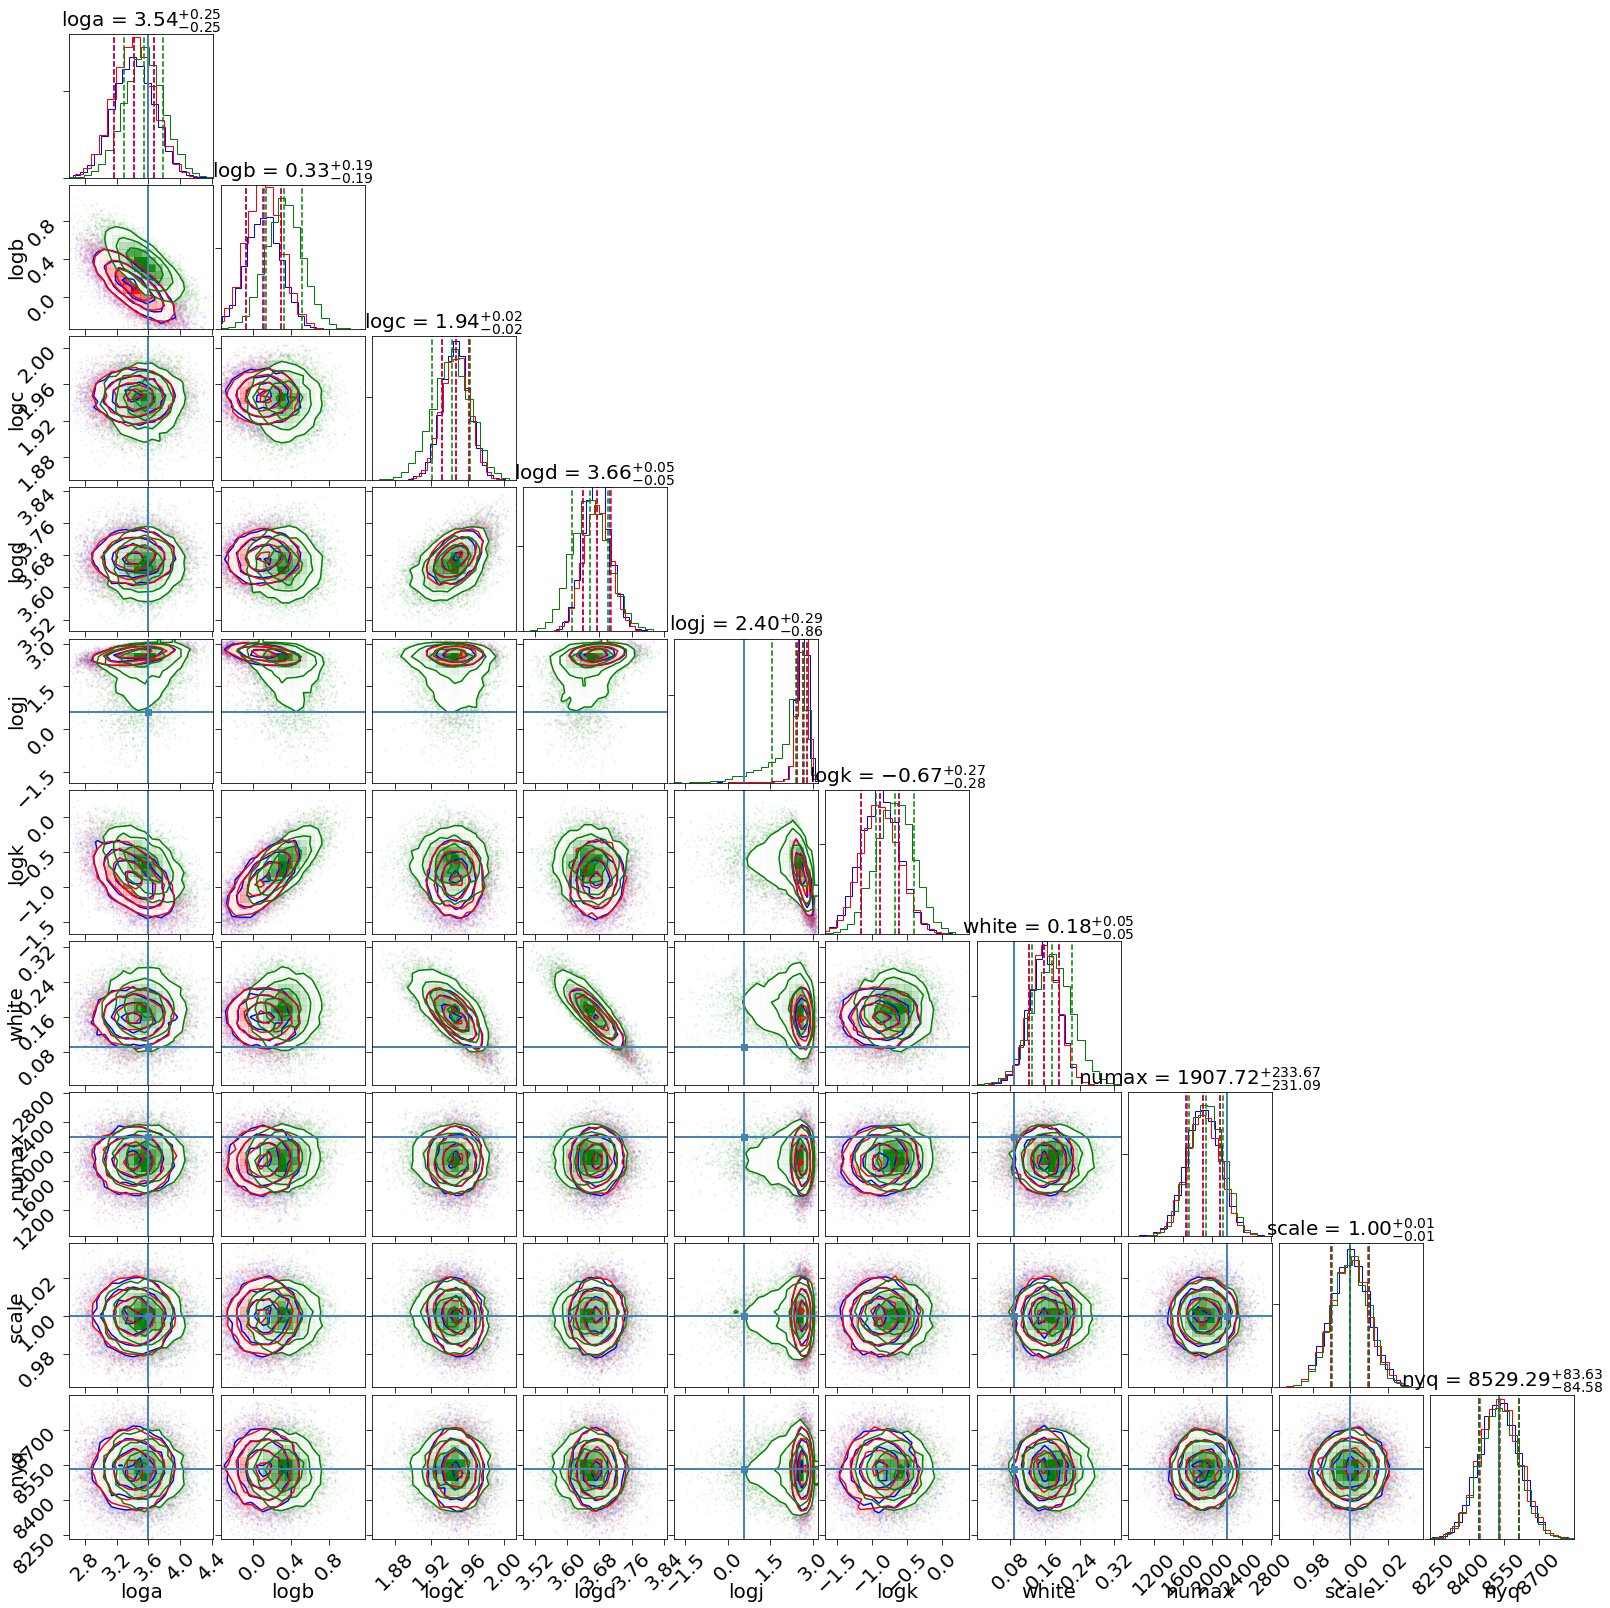

In [37]:
labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
chain = np.array([fit[label] for label in labels])
bin_chain = np.array([bin_fit[label] for label in labels])
mean_chain = np.array([mean_fit[label] for label in labels])

fig = corner.corner(chain.T, labels=labels, color='blue', truths=truths, quantiles=[0.16, 0.5, 0.84],show_titles=True)
corner.corner(bin_chain.T, fig=fig, color='red', labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84],show_titles=True)
corner.corner(mean_chain.T, fig=fig, color='green', labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84],show_titles=True)

plt.show()

In [42]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, numax, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

def out_modelplot(fit):
    labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
    res = np.array([np.median(fit[label]) for label in labels])
    res[0:6] = 10**res[0:6]
    bin_res = np.array([np.median(bin_fit[label]) for label in labels])
    bin_res[0:6] = 10**bin_res[0:6] 
    mean_res = np.array([np.median(mean_fit[label]) for label in labels])
    mean_res[0:6] = 10**mean_res[0:6]        
    model = get_background(f, *res)
    bin_model = get_background(bin_f, *bin_res)
    mean_model = get_background(mean_f, *mean_res)


    pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
    ax = pg.plot(alpha=.25, label='Data', scale='log')
#     ax.plot(bin_f, bin_p)    
    ax.plot(f, model, label='Model')
    ax.plot(bin_f, bin_model, label='Bin Model')
    ax.plot(mean_f, mean_model, label='Model')
    
#     ax.plot(f, harvey(f, res[0],res[1], 4.), label='Harvey 1', ls=':')
#     ax.plot(f, harvey(f, res[2],res[3], 4.), label='Harvey 2', ls=':')
#     ax.plot(f, harvey(f, res[4],res[5], 2.), label='Harvey 3', ls=':')
#     ax.plot(f, get_apodization(f, f[-1]), label='Apod', ls='--')
#     ax.plot(f, res[-4]*np.ones_like(f), label='white',ls='-.')
    plt.legend(fontsize=10)
    ax.set_ylim(p.min(), p.max())
    plt.show()

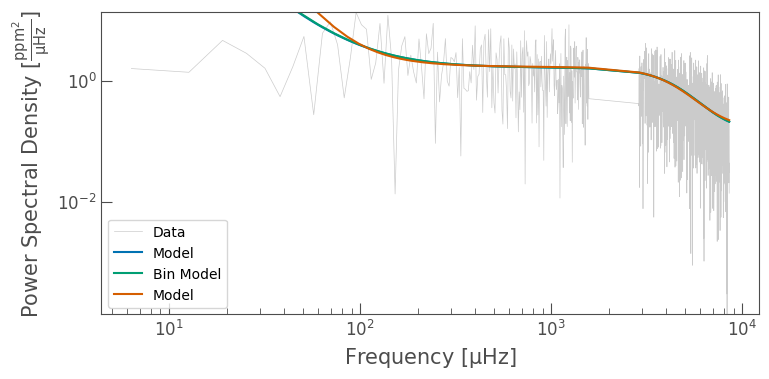

In [43]:
out_modelplot(fit)

In [46]:
labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
res = np.array([np.median(fit[label]) for label in labels])
res[0:6] = 10**res[0:6]
bin_res = np.array([np.median(bin_fit[label]) for label in labels])
bin_res[0:6] = 10**bin_res[0:6] 
mean_res = np.array([np.median(mean_fit[label]) for label in labels])
mean_res[0:6] = 10**mean_res[0:6]        
model = get_background(f, *res)
bin_model = get_background(bin_f, *bin_res)
mean_model = get_background(mean_f, *mean_res)

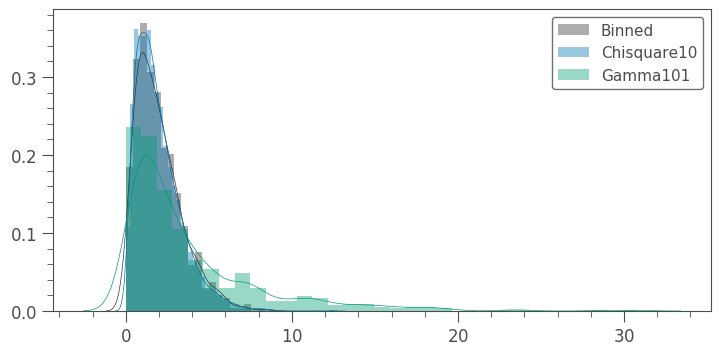

In [69]:
import seaborn as sns
with plt.style.context(ms.ms):
#     sns.distplot(p/model, label='Raw')
    sns.distplot(bin_p/bin_model, label='Binned')
#     sns.distplot(mean_p/mean_model, label='Mean')    
    
#     sns.distplot(np.random.chisquare(2, 10000)/2, label='Chisquare')
    sns.distplot(np.random.chisquare(2*binsize, 10000)/2, label='Chisquare10')   
    sns.distplot(np.random.gamma(binsize, 1./bin_model), label='Gamma101')
    plt.legend()

In [ ]:
sys.exit()

In [ ]:
import pickle
with open('backfit_sim.pkl', 'wb') as file:
    pickle.dump(fit.extract(), file)